In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [14]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction
def gauss_dist(norms, alpha, c, b):
    # Gaussian distance function
    return c*np.exp(-alpha*(norms**2)) + b

In [114]:
def attraction_to_flower_gaussian(attraction_differences, distance, distance_norms, alpha=1, c=1, b=0):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    net_attraction = (velocity_unit_vector * gauss_dist(distance_norms, alpha, c, b)) / (1 + attraction_norm)

    return net_attraction


In [115]:
def attraction_to_flower_inverse(attraction_differences, distance, distance_norms, alpha=1, c=1, b=0):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    net_attraction = (velocity_unit_vector * (1/distance_norms)) / (1 + attraction_norm)

    return net_attraction


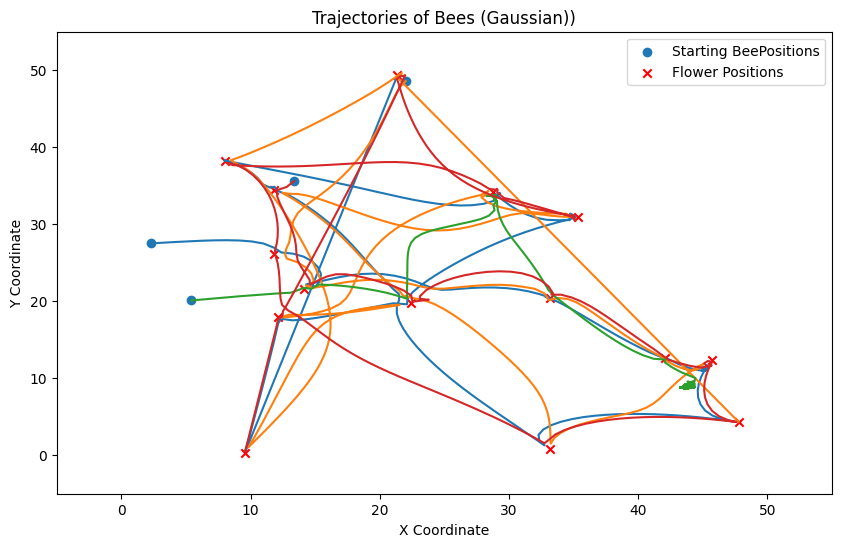

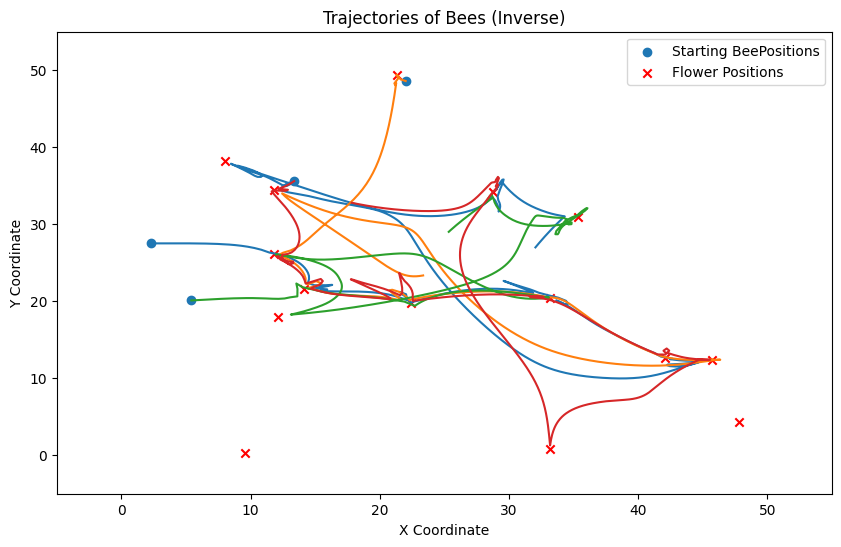

In [120]:
flower_qnty = 15
bee_qnty = 4
max_attraction = 4
max_position = 50
features = 5
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Define parameters and initial conditions
t_steps = 1000
t_final = 100
t_vals = np.linspace(0,t_final,t_steps)
nu = 10  # Parameter for the ODE
xsi = 0.2  # Parameter for the ODE
alpha = 0.2 / max_position  # Parameter for the ODE
c = 10
b = 0.5
eps = 1  # Proximity threshold for flower visitation



seconds_at_flower =  2
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))
def ode(t, x_flat, T_i):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))
    distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_norms = np.linalg.norm(distance, axis=0)

    T_i -= (distance_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0

    attractors = attraction_to_flower_gaussian(attraction_differences, distance, distance_norms, alpha, c, b)

    attractors = attractors*gamma

    combined_vector = attractors.sum(axis=2)
    
    velocity = (nu * combined_vector) / (xsi + np.linalg.norm(combined_vector, axis=0))

    # return the velocity for each bee
    return velocity.flatten()


# ode(0, bee_positions, T_i)

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(10, 6))



for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y)

plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting BeePositions')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees (Gaussian))')
plt.xlim(-5,max_position + 5)
plt.ylim(-5,max_position + 5)
plt.legend()

plt.show()



T_i = np.ones((bee_qnty, flower_qnty))
def ode(t, x_flat, T_i):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))
    distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_norms = np.linalg.norm(distance, axis=0)

    T_i -= (distance_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0

    attractors = attraction_to_flower_inverse(attraction_differences, distance, distance_norms, alpha, c, b)

    attractors = attractors*gamma

    combined_vector = attractors.sum(axis=2)
    
    velocity = (nu * combined_vector) / (xsi + np.linalg.norm(combined_vector, axis=0))

    # return the velocity for each bee
    return velocity.flatten()


# ode(0, bee_positions, T_i)

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(10, 6))



for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y)

plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting BeePositions')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees (Inverse)')
plt.xlim(-5,max_position + 5)
plt.ylim(-5,max_position + 5)
plt.legend()

plt.show()

